## The most basic end-to-end pipeline 

Required user inputs:

- Which constellation (Sentinel1, Sentinel2). Also provide support (i.e. default STAC metadata) for other collections? 
- Which bands --> for S2, allow option to chose distance_to_cloud or scl_dilation_mask as a band
- Temporal extent
- Reference dataset --> Require standardized input format?
- Patch (if so, which size/shape?) or point?
- Which openEO backend(s)

## Reference data

First of all, the reference data needs to be read in. In the example we use 20 geometries belonging to the same S2 tile.

We can think about a normalize_reference_data, to make sure the reference data is in the correct format

In [1]:
import geopandas as gpd

base_df = gpd.read_file('./ref_data/sample_jobs.geojson')
base_df

,sample_id,landcover_label,croptype_label,irrigation_label,valid_date,ref_id,tile,geometry
0,2021_BE_Flanders_full_2195082011,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.70009 51.08117)
1,2021_BE_Flanders_full_1010873978,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (3.05771 51.20072)
2,2021_BE_Flanders_full_2195311171,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.65647 50.92515)
3,2021_BE_Flanders_full_936816805,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (3.03073 51.19602)
4,2021_BE_Flanders_full_1961534808,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (3.02891 51.19640)
5,2021_BE_Flanders_full_2194143333,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.57456 51.06969)
6,2021_BE_Flanders_full_2075647224,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.72138 51.13372)
7,2021_BE_Flanders_full_2191190590,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.84396 51.09410)
8,2021_BE_Flanders_full_935326035,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.63926 50.91796)
9,2021_BE_Flanders_full_2195520329,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,POINT (2.87549 51.08698)


## Extractions

First we need do do some extractions based on reference data. Here already a lot of variety is possible. We distinguish between point and patch extractions.

### Point Extractions

In [2]:
# Some user defined parameters
temporal_extent = ["2020-01-01", "2020-01-15"]
collection = "SENTINEL2_L2A"  # These names are standardized in GFMap
bands = ["B02", "B03", "B04"]  # These names are standardized in GFMap
backend = "openeo.vito.be"  # This name is standardized in GFMap

In [3]:
import openeo
c = openeo.connect(backend).authenticate_oidc()
raw_extraction = c.load_collection(collection_id=collection, 
                                   bands=bands, 
                                   temporal_extent=temporal_extent)

Authenticated using refresh token.


Here the user already has a lot of choices:
- Do they want to extract the raw data without any form of preprocessing? 
- Do they want to perform some form of compositing?
- Do they want to perform some cloud masking?
- Do they want to apply extra features on top of the vanilla bands?

So in GFMap there should be the option do immediately do a raw extraction in patch or point form, where only the raw bands are extracted (possible to add distance_to_cloud and cloud_mask). In this option the user extracts data that still has a time dimension.
There should also be the option to first perform preprocessing and feature computation (do we set a default, does the user have to specify? what about bespoke methods like Presto?) and only then do the extractions. In this option the user extracts data without time dimension.

It should also be possible (like in worldcereal e.g.) that the user does both of the above. First extract raw, then load in again with `load_stac`, and only then do feature computation and extract again. 

Let's for now do feature computation and only then extractions.

In [4]:
from openeo.rest.datacube import DataCube

In [5]:
def calculate_features(cube: openeo.rest.datacube.DataCube) -> openeo.rest.datacube.DataCube:
    from openeo.processes import ProcessBuilder, array_concat
    
    # Calculate for each band the 10%, 50% and 90% quantiles and the standard deviation
    def compute_features(input_timeseries:ProcessBuilder):
        return array_concat(input_timeseries.quantiles(probabilities=[0.1,0.5,0.9]),input_timeseries.sd())

    # Use apply_dimension to remove the time dimension and map the quantiles to the band dimension
    # Sentinel-2 data is in int16, use linear_scale_range to convert to int8
    features = cube.apply_dimension(dimension='t',target_dimension='bands', process=compute_features).apply(lambda x: x.linear_scale_range(0,65535,0,255))

    # Finally, rename the bands to reflect the computed features
    all_bands = [band + "_" + stat for band in cube.metadata.band_names for stat in ["p10","p50","p90","sd"]]
    features = features.rename_labels('bands',all_bands)

    return features, all_bands

In [6]:
features, all_bands = calculate_features(raw_extraction)

Based on the reference data, we need to sample a point per sample_id. Currently the geometries are already Points, so no conversion is needed. Commented is a piece of code that would convert to Point geometries in case they were not already.

In [7]:
# # Set the coordinates to UTM to accurately calculate centroids
# proj_base_df = base_df.to_crs(base_df.estimate_utm_crs())
# # Take the centroid of the geometry as Point --> could also make a random point within the geometry
# proj_base_df.geometry = proj_base_df.geometry.centroid
# # Drop the columns confidence and extract, since json converts None to null and True to true, so it's not parsable.
# proj_base_df = proj_base_df.to_crs(epsg=4326)  # Convert back to WGS84, as required by geojson

# json changes True to true, False to false and None to null. This is not parsable so we need to add a check that these properties are removed.
geom = eval(base_df.to_json())

geom

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {'sample_id': '2021_BE_Flanders_full_2195082011',
    'landcover_label': 11,
    'croptype_label': 1520,
    'irrigation_label': 0,
    'valid_date': '2021-06-01',
    'ref_id': '2021_EUR_DEMO_POLY_110',
    'tile': '31UDS'},
   'geometry': {'type': 'Point',
    'coordinates': [2.700085999992169, 51.081172216239715]}},
  {'id': '1',
   'type': 'Feature',
   'properties': {'sample_id': '2021_BE_Flanders_full_1010873978',
    'landcover_label': 11,
    'croptype_label': 1120,
    'irrigation_label': 0,
    'valid_date': '2021-06-01',
    'ref_id': '2021_EUR_DEMO_POLY_110',
    'tile': '31UDS'},
   'geometry': {'type': 'Point',
    'coordinates': [3.057707187625569, 51.20072475737662]}},
  {'id': '2',
   'type': 'Feature',
   'properties': {'sample_id': '2021_BE_Flanders_full_2195311171',
    'landcover_label': 11,
    'croptype_label': 1120,
    'irrigation_label': 0,
    'valid_date': '2021-06

Aggregate the features to the point geometries and save as geoparquet. The following VectorCube issue in the Geopyspark Driver needs to be solved:

- [723](https://github.com/Open-EO/openeo-geopyspark-driver/issues/723): Band names are lost after `aggregate_spatial`

In [8]:
point_features = features.aggregate_spatial(geometries=geom, reducer="mean")  # The reducer is not relevant for point aggregation
#  point_features = point_features.rename_labels('bands', all_bands)  # we want to support this in the feature, or immediately make it so that band names are not lost after aggregate_spatial

job = point_features.execute_batch(
    title='Point feature extraction',
    out_format='Parquet',
)
results = job.get_results()
results.download_file('point_features.parquet')

In [9]:
import geopandas as gpd
df = gpd.read_parquet('point_features.parquet')

# The below is only necessary as long as (https://github.com/Open-EO/openeo-geopyspark-driver/issues/723) isn't fixed
wrong_band_names = [f'avg_band_{i}_' for i in range(len(all_bands))]
df = df.rename(columns=dict(zip(wrong_band_names, all_bands)))
df.head()

,geometry,sample_id,landcover_label,croptype_label,irrigation_label,valid_date,ref_id,tile,feature_index,B02_p10,...,B02_p90,B02_sd,B03_p10,B03_p50,B03_p90,B03_sd,B04_p10,B04_p50,B04_p90,B04_sd
0,POINT (2.70009 51.08117),2021_BE_Flanders_full_2195082011,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,0,2.0,...,81.0,39.0,2.0,81.0,81.0,39.0,2.0,81.0,81.0,39.0
1,POINT (3.05771 51.20072),2021_BE_Flanders_full_1010873978,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,1,1.0,...,81.0,43.0,2.0,43.0,81.0,42.0,2.0,43.0,81.0,42.0
2,POINT (2.65647 50.92515),2021_BE_Flanders_full_2195311171,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,2,2.0,...,81.0,41.0,3.0,44.0,81.0,41.0,1.0,44.0,81.0,42.0
3,POINT (3.03073 51.19602),2021_BE_Flanders_full_936816805,11,1520,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,3,1.0,...,81.0,43.0,2.0,42.0,81.0,43.0,3.0,42.0,81.0,42.0
4,POINT (3.02891 51.19640),2021_BE_Flanders_full_1961534808,11,1120,0,2021-06-01,2021_EUR_DEMO_POLY_110,31UDS,4,2.0,...,81.0,42.0,2.0,43.0,81.0,42.0,3.0,43.0,81.0,42.0


In [ ]:
{1520: 'Spring Barley', 1120: 'Spring Wheat', 4351: 'Winter Rapeseed', 4352: 'Spring Rapeseed'}

In [14]:
df['croptype_label'].unique()

array([1520, 1120, 4351, 4352])

### Patch Extractions

TODO

## Model Training

Note that there will not be a lot of scientific accuray in the model training and inference below. The code is just to illustrate how a user could use a UDF based on ONNX to perform training and inference.

In [10]:
from sklearn.model_selection import train_test_split

X, y = df[all_bands], df['croptype_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False)
model.fit(X_train, y_train)

model.save_model('catboost.onnx', format='onnx')


## Inference

In [12]:
spatial_extent = {'west': 5.055754, 'south': 51.308433, 'east': 5.072190, 'north': 51.317712}
s2 = c.load_collection(collection_id=collection, 
                                   bands=bands, 
                                   temporal_extent=temporal_extent,
                                   spatial_extent=spatial_extent)

features, all_bands = calculate_features(s2)

model_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/catboost_onnx/catboost.onnx"
udf = openeo.UDF.from_file(
    "udf_catboost_onnx.py", 
    context={
        "model_url": model_url
    }
)

# Reduce the bands dimesnion to a single prediction using the udf
prediction = features.reduce_bands(reducer=udf)
# This step ensures the datatype is unint8
# prediction = prediction.linear_scale_range(0.0,255.0,0,255)

# Add the onnx dependencies to the job options. You can reuse this existing dependencies archive
dependencies_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/onnx_dependencies_1.16.3.zip"
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps"
    ],
}

job = prediction.execute_batch(
    title='Crop type prediction',
    out_format='GTiff',
    job_options=job_options
)
results = job.get_results()
results.download_files('./results/')

0:00:00 Job 'j-240430ad758a47bd9ababd780bb6d659': send 'start'
0:00:19 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:00:24 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:00:31 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:00:39 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:00:49 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:01:01 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:01:17 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:01:36 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:02:00 Job 'j-240430ad758a47bd9ababd780bb6d659': queued (progress N/A)
0:02:30 Job 'j-240430ad758a47bd9ababd780bb6d659': running (progress N/A)
0:03:08 Job 'j-240430ad758a47bd9ababd780bb6d659': running (progress N/A)
0:03:55 Job 'j-240430ad758a47bd9ababd780bb6d659': running (progress N/A)
0:04:53 Job 'j-240430ad758a47bd9ababd780bb6d659': finished (progress N

[PosixPath('results/openEO.tif'), PosixPath('results/job-results.json')]

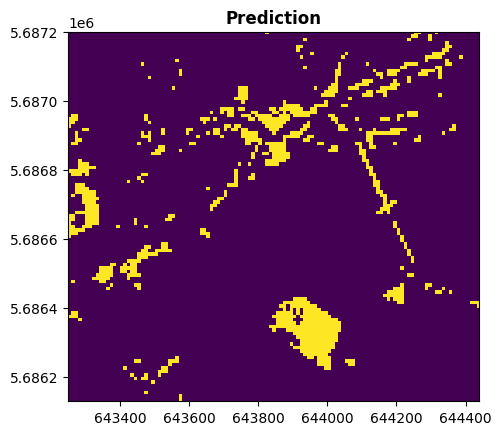

In [13]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

path = './results/openEO.tif'

with rasterio.open(path, dtype="uint8") as src:
    show(src, title="Prediction", cmap="viridis")


